In [1]:
from dataloader import GraphTextDataset, GraphDataset, TextDataset
from torch_geometric.data import DataLoader
from torch.utils.data import DataLoader as TorchDataLoader
from Model import Model, ModelGIN
import numpy as np
from transformers import AutoTokenizer
import torch.nn.functional as F
import torch
from torch import optim
import time
import os
import pandas as pd 
from utils.utils import create_folders_if_not_exist
import argparse
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.metrics.pairwise import cosine_similarity
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.utils import degree
import random
import torch_geometric
from torch_geometric.data import Data, Batch
import matplotlib.pyplot as plt

import numpy as np
import os
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance
from functools import partial

from utils.data_utils import get_list_graphs, get_augmented_batch, load_embeddings, compute_vector_direction_mean
from utils.data_utils import compute_vector_direction
from scores import Cosine, Dot, Score_Direction_dot, Score_Direction_cos, compute_evolution_2
# import seaborn as sns

# # Set Seaborn style
# sns.set()

%load_ext autoreload
%autoreload 2

### Load the model and the data

In [2]:
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
gt = np.load("./data/token_embedding_dict.npy", allow_pickle=True)[()]
train_dataset = GraphTextDataset(root='./data/', gt=gt, split='train', tokenizer=tokenizer)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModelGIN(model_name, num_node_features=300, dim_h=600, dim_encode=768)
model.to(device)
name_exp = "SciBert_Loss_GIN"
checkpoint = torch.load('./checkpoints/' + name_exp + '/model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
graph_model = model.get_graph_encoder() ### get the model needed for the graph
graph_model.eval()

GINEncoder(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=300, out_features=600, bias=True)
    (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=600, out_features=600, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=600, out_features=600, bias=True)
    (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=600, out_features=600, bias=True)
    (4): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=600, out_features=600, bias=True)
    (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=600, out_features=600, bias=True)
    (4): ReLU()
  ))
  (lin1): Linear(in_features=1800, out_features=1800, bias=True)
  (lin2): Linear(in_features=1800, out_features=768, bias=True)
)

### Compute the concept vectors

In [4]:
name_exp = 'SciBert_Loss_GIN'
embedding_folder = f'/Data/CTey/embeddings/text/{name_exp}/'
text_embds = load_embeddings(embedding_folder)

embedding_folder = f'/Data/CTey/embeddings/graph/{name_exp}/'
graph_embds = load_embeddings(embedding_folder)

concept_vectors = torch.Tensor(compute_vector_direction_mean(text_embds)).to(device)

### Select your subset

In [5]:
n_nodes = 22 
L_graphs, L_graphs_idx = get_list_graphs(train_dataset, n_nodes, lim=1e7)

/users/eleves-b/2020/benjamin.lapostolle/genhack/genhack/lib64/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
  0%|                                                                                            | 0/53 [00:02<?, ?it/s]


### Plot the evolution of the scores functions

In [20]:
### chose your score function

score = Score_Direction_dot(concept_vectors)
#score = Cosine()
#score = Dot()

In [21]:
### Compute the scores 

iter_MC = 100
use_directions = True #if a score function leveraging concept vectors is used, else set to False

score_samples = compute_evolution_2(L_graphs, L_graphs_idx, n_nodes, score, graph_model, iter_MC, concept_vectors, use_directions)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


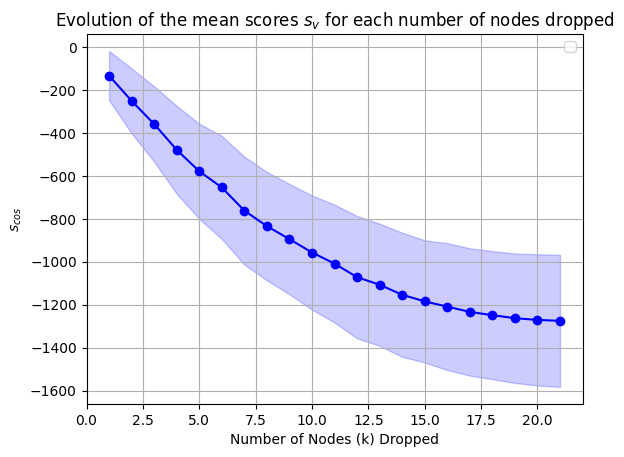

In [22]:
#### plot the evolutions 

# Compute the mean and standard deviation for each key in the dictionary
means = []
stds = []
for k in range(1, n_nodes):
    means.append(np.mean(score_samples[k]))
    stds.append(np.std(score_samples[k]))

# Plotting the mean and standard deviation
# plt.errorbar(range(1, 22), means, yerr=stds, fmt='-o')
# plt.xlabel('Number of Nodes (k)')
# plt.ylabel('Score')
# plt.title('Mean and Standard Deviation of Scores for Each Number of Nodes')
# plt.grid(True)
# plt.show()
# for neighbor in range(1, 10, 5):
#     plt.axhline(y=mean_neighbors[neighbor], color='red', linestyle='--', alpha=0.7, label=f'Mean closest neighbor {neighbor}')
plt.legend()
# Plotting the mean with a colored area representing the standard deviation
plt.fill_between(range(1, n_nodes), np.array(means) - np.array(stds), np.array(means) + np.array(stds), color='blue', alpha=0.2)
plt.plot(range(1, n_nodes), means, '-o', color='blue')
plt.xlabel('Number of Nodes (k) Dropped')
plt.ylabel('$s_{cos}$')
plt.title('Evolution of the mean scores $s_v$ for each number of nodes dropped')
plt.grid(True)
plt.savefig('cosine.png')
plt.show()

### Compute the score of the nearest neighbors

In [12]:
### load the similarity matrix 

nearest_values = np.load('/Data/CTey/similarity/SciBert_Loss_GIN/top_values.npy')

In [13]:
A = nearest_values[L_graphs_idx,:]
mean_neighbors, std_neighbors = {}, {}
for neighbor in range(1, 10):
    mean_neighbors[neighbor] = np.mean(A[:,-1-neighbor])
    std_neighbors[neighbor] = np.std(A[:,-1-neighbor])

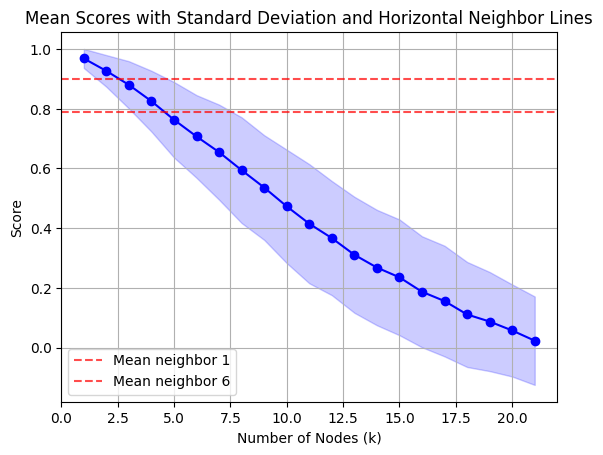

In [14]:
mean_neighbors = {neighbor: np.mean(A[:, -1 - neighbor]) for neighbor in range(1, 10)}
std_neighbors = {neighbor: np.std(A[:, -1 - neighbor]) for neighbor in range(1, 10)}

# Plotting the mean with a colored area representing the standard deviation
plt.fill_between(range(1, n_nodes), np.array(means) - np.array(stds), np.array(means) + np.array(stds), color='blue', alpha=0.2)
plt.plot(range(1, n_nodes), means, '-o', color='blue')

# Adding horizontal lines for each mean neighbor value
for neighbor in range(1, 10, 5):
    plt.axhline(y=mean_neighbors[neighbor], color='red', linestyle='--', alpha=0.7, label=f'Mean neighbor {neighbor}')

    # Adding shaded area for std deviation of neighbors
    # plt.fill_between(range(1, 22), mean_neighbors[neighbor] - std_neighbors[neighbor], mean_neighbors[neighbor] + std_neighbors[neighbor], color='red', alpha=0.1)

plt.xlabel('Number of Nodes (k)')
plt.ylabel('Score')
plt.title('Mean Scores with Standard Deviation and Horizontal Neighbor Lines')
plt.grid(True)
plt.legend()
plt.show()

# Experiment 2: leveraging example importance methods

In [15]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# Before executing this part, make sure you created your file containing the results.
# Load the data from the saved file
with open('./results/ex_importance/all22grareal.pkl', 'rb') as f:
    res_loaded = pickle.load(f)

In [17]:
features_importance_n_nodes = {}
for n_node in range(1,8):
    features_importance_n_nodes[n_node] = []
    for idx in range(len(res_loaded)):
        features_importance_n_nodes[n_node] += res_loaded[idx][n_node][0]

means = [np.mean(features_importance_n_nodes[n_node]) for n_node in range(1,8)]
stds = [np.std(features_importance_n_nodes[n_node]) for n_node in range(1,8)]

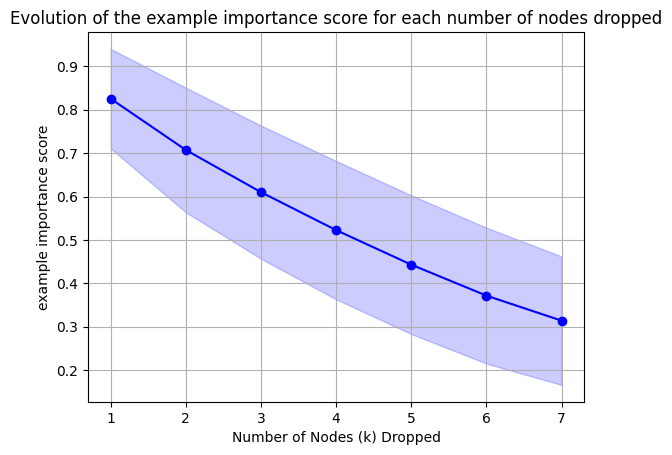

In [18]:
plt.fill_between(range(1, 8), np.array(means) - np.array(stds), np.array(means) + np.array(stds), color='blue', alpha=0.2)
plt.plot(range(1, 8), means, '-o', color='blue')
plt.xlabel('Number of Nodes (k) Dropped')
plt.ylabel('example importance score')
plt.title('Evolution of the example importance score for each number of nodes dropped')
plt.grid(True)
plt.savefig('ex_importance_score.png')
plt.show()

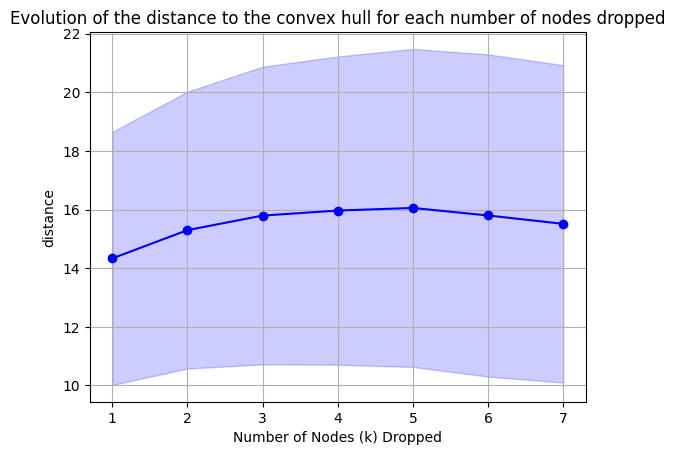

In [19]:
rest_importance_n_nodes = {}
for n_node in range(1,8):
    rest_importance_n_nodes[n_node] = []
    for idx in range(len(res_loaded)):
        rest_importance_n_nodes[n_node] += np.sqrt(res_loaded[idx][n_node][1]).tolist()

means_rest = [np.mean(rest_importance_n_nodes[n_node]) for n_node in range(1,8)]
stds_rest = [np.std(rest_importance_n_nodes[n_node]) for n_node in range(1,8)]

plt.fill_between(range(1, 8), np.array(means_rest) - np.array(stds_rest), np.array(means_rest) + np.array(stds_rest), color='blue', alpha=0.2)
plt.plot(range(1, 8), means_rest, '-o', color='blue')
plt.xlabel('Number of Nodes (k) Dropped')
plt.ylabel('distance')
plt.title('Evolution of the distance to the convex hull for each number of nodes dropped')
plt.grid(True)
plt.savefig('distance_remaining.png')
plt.show()